In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import concurrent.futures
import time
from tqdm import tqdm
import json

In [3]:
# Define the list of commercial vehicle brands to scrape

COMMERCIAL_BRANDS = [
    'Mercedes-Benz', 
    'Volkswagen', 
    'Ford', 
    'Opel', 
    'Renault', 
    'Peugeot', 
    'Iveco', 
    'Citroën', 
    'Fiat', 
    'MAN'
]

# Define price ranges (the tighter the range, the more pages/data will be scraped)
PRICE_RANGES = [
    (2500, 4999),
    (5000, 7499),
    (7500, 9999),
    (10000, 11249),
    (11250, 12499),
    (12500, 13749),
    (13750, 14999),
    (15000, 16249),
    (16250, 17499),
    (17500, 18749),
    (18750, 19999),
    (20000, 21249),
    (21250, 22499),
    (22500, 23749),
    (23750, 24999),
    (25000, 26249),
    (26250, 27499),
    (27500, 28749),
    (28750, 29999),
    (30000, 32499),
    (32500, 34999),
    (35000, 37499),
    (37500, 39999),
    (40000, 42499),
    (42500, 44999),
    (45000, 47499),
    (47500, 49999),
    (50000, 52499),
    (52500, 54999),
    (55000, 57499),
    (57500, 59999)
]


In [4]:
# Function to scrape search results using BeautifulSoup
def scrape_search_results_bs(make, price_min, price_max, page=1):
    base_url = f"https://www.autoscout24.com/lst/{make.lower()}"
    params = {
        'body': '13', # Commercial vehicles
        'cy': 'D,A,B,E,F,I,L,NL', # Countries to search in
        'offer': 'U',
        'pricefrom': str(price_min),
        'priceto': str(price_max),
        'fregfrom': '2015',
        'page': str(page),
        'sort': 'standard',
        'source': 'listpage_pagination',
        'ustate': 'N,U',
        'atype': 'C',
        'desc': '0',
        'damaged_listing': 'exclude'
    }
    try:
        response = requests.get(base_url, params=params, timeout=15)
        soup = BeautifulSoup(response.text, 'html.parser')
        listings = []
        for item in soup.find_all('div', class_='ListItem_wrapper__TxHWu'):
            img_tag = item.find('img', class_='NewGallery_img__cXZQC')
            img_url = img_tag['src'] if img_tag and 'src' in img_tag.attrs else ''
            title_link = item.find('a', class_='ListItem_title__ndA4s')
            url = title_link['href'] if title_link and 'href' in title_link.attrs else ''
            if url and not url.startswith('http'):
                url = 'https://www.autoscout24.com' + url
            title = ''
            if title_link:
                h2_tag = title_link.find('h2')
                if h2_tag:
                    title = ' '.join([span.get_text(strip=True) for span in h2_tag.find_all('span')])
            price_tag = item.find('p', class_='Price_price__APlgs')
            price = price_tag.get_text(strip=True) if price_tag else ''
            location = ''
            sellerinfo_section = item.find_next('div', class_='SellerInfo_wrapper__XttVo')
            if sellerinfo_section:
                address_tag = sellerinfo_section.find('span', class_='SellerInfo_address__leRMu')
                location = address_tag.get_text(strip=True) if address_tag else ''
            details = {}
            for detail_span in item.find_all('span', class_='VehicleDetailTable_item__4n35N'):
                label = detail_span.get('aria-label', '')
                value = detail_span.get_text(strip=True)
                details[label] = value
            search_params = '&'.join([f'{k}={v}' for k, v in params.items()])
            listings.append({
                'title': title,
                'url': url,
                'price': price,
                'location': location,
                'mileage': details.get('Mileage', ''),
                'gearbox': details.get('Gear', ''),
                'registration': details.get('First registration', ''),
                'fuel': details.get('Fuel type', ''),
                'power': details.get('Power', ''),
                'img_url': img_url,
                'search_make': make,
                'search_body': params['body'],
                'search_page': page,
                'search_params': search_params,
                'cy': params['cy'],
                'offer': params['offer'],
                'pricefrom': params['pricefrom'],
                'fregfrom': params['fregfrom'],
                'brand': make,
                'priceto': params['priceto'],
                'price_range': f'{price_min}-{price_max}'
            })
        return listings
    except Exception as e:
        print(f"Error scraping {make} {price_min}-{price_max} page {page}: {e}")
        return []

In [ ]:
# Prepare the output file
bs4_listings_file = os.path.join('data', 'as24_listings_bs4.parquet')

try:
    existing_df = pd.read_parquet(bs4_listings_file, engine='fastparquet')
    existing_urls = set(existing_df['url'].dropna().unique())
except Exception:
    existing_df = pd.DataFrame()
    existing_urls = set()

for brand in COMMERCIAL_BRANDS:
    for price_min, price_max in PRICE_RANGES:
        print(f"Scraping {brand} {price_min}-{price_max} concurrently")
        pages = list(range(1, 21))
        new_listings = []
        skip_category = False
        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor: # max 4 workers for concurrency, more will likely encounter rate limits
            results = list(executor.map(lambda page: scrape_search_results_bs(brand, price_min, price_max, page), pages))
        for page, listings in zip(pages, results):
            if not listings:
                print(f"  No listings found on page {page} for {brand} {price_min}-{price_max}, skipping to next category.")
                skip_category = True
                break  # Skip to next price range or brand
            page_new_urls = set(l['url'] for l in listings if l['url'] not in existing_urls)
            print(f"  Found {len(page_new_urls)} new listings on page {page}")
            page_new_listings = [l for l in listings if l['url'] in page_new_urls]
            new_listings.extend(page_new_listings)
            existing_urls.update(page_new_urls)
            time.sleep(0.2)
        
        # Always save intermittently before skipping category
        if new_listings:
            try:
                existing_df = pd.read_parquet(bs4_listings_file, engine='fastparquet')
                combined_df = pd.concat([existing_df, pd.DataFrame(new_listings)], ignore_index=True)
            except Exception:
                combined_df = pd.DataFrame(new_listings)
            combined_df.drop_duplicates(subset=['url'], inplace=True)
            combined_df.to_parquet(bs4_listings_file, index=False, engine='fastparquet')
            print(f"  Saved {len(combined_df)} total listings to {bs4_listings_file}")
            existing_urls = set(combined_df['url'].dropna().unique())
        else:
            print("  No new listings to save for this brand/price range.")
        if skip_category:
            continue

# Show summary
try:
    final_df = pd.read_parquet(bs4_listings_file, engine='fastparquet')
    print(f"Final count: {len(final_df)} listings in {bs4_listings_file}")
    display(final_df.head())
except Exception as e:
    print(f"Could not read final parquet file: {e}")

In [ ]:
# define a function to scrape vehicle details from a given URL
def get_vehicle_details(url):
    try:
        response = requests.get(url, timeout=15)
        soup = BeautifulSoup(response.text, 'html.parser')
        details = {}
        # Title (model name)
        title_tag = soup.find('h1')
        details['model_name'] = title_tag.get_text(strip=True) if title_tag else ''
        # Price (main price selector)
        price_tag = soup.find('span', class_='PriceInfo_price__XU0aF')
        details['price'] = price_tag.get_text(strip=True) if price_tag else ''
        # Seller type
        seller_type_tag = soup.find('div', class_='SellerInfo_sellerType__1fG2G')
        details['seller_type'] = seller_type_tag.get_text(strip=True) if seller_type_tag else ''
        # Location
        location_tag = soup.find('div', class_='SellerInfo_location__1nJ1B')
        details['location'] = location_tag.get_text(strip=True) if location_tag else ''
        # Vehicle overview details (mileage, gearbox, registration, fuel, power, seller)
        overview_section = soup.find('div', class_='StageArea_overviewContainer__UyZ9n')
        if overview_section:
            for item in overview_section.find_all('div', class_='VehicleOverview_itemContainer__XSLWi'):
                title_tag = item.find('div', class_='VehicleOverview_itemTitle__S2_lb')
                value_tag = item.find('div', class_='VehicleOverview_itemText__AI4dA')
                if title_tag and value_tag:
                    details[title_tag.get_text(strip=True)] = value_tag.get_text(strip=True)
        # Extract all details from DetailsSection_detailsSection__FJZXR sections
        for section in soup.find_all('div', class_='DetailsSection_detailsSection__FJZXR'):
            title = section.find('h2', class_='DetailsSectionTitle_text__KAuxN')
            if title and 'Equipment' in title.get_text():
                equipment = {}
                dl = section.find('dl')
                if dl:
                    dts = dl.find_all('dt')
                    dds = dl.find_all('dd')
                    for dt, dd in zip(dts, dds):
                        key = dt.get_text(strip=True)
                        ul = dd.find('ul')
                        if ul:
                            value = [li.get_text(strip=True) for li in ul.find_all('li')]
                        else:
                            value = dd.get_text(strip=True)
                        equipment[key] = value
                # Ensure equipment is JSON-serializable
                try:
                    details['equipment'] = json.dumps(equipment, ensure_ascii=False)
                except Exception:
                    details['equipment'] = str(equipment)
            elif title and 'Colour and Upholstery' in title.get_text():
                dl = section.find('dl')
                if dl:
                    dts = dl.find_all('dt')
                    dds = dl.find_all('dd')
                    for dt, dd in zip(dts, dds):
                        key = dt.get_text(strip=True)
                        value = dd.get_text(strip=True)
                        details[key] = value
            elif title and 'Vehicle Description' in title.get_text():
                desc_section = section.find('div', id='sellerNotesSection')
                if desc_section:
                    content = desc_section.find('div', class_='SellerNotesSection_content__te2EB')
                    if content:
                        details['description'] = content.get_text(separator=' ', strip=True)
            else:
                dl = section.find('dl', class_='DataGrid_defaultDlStyle__xlLi_')
                if dl:
                    dts = dl.find_all('dt')
                    dds = dl.find_all('dd')
                    for dt, dd in zip(dts, dds):
                        key = dt.get_text(strip=True)
                        value = dd.get_text(strip=True)
                        details[key] = value
        # Body type, Type, Drivetrain, Seats, Doors, Model code, Previous owner, etc.
        for row in soup.find_all('div', class_='VehicleDetailTable_item__4n35N'):
            label = row.get('aria-label', '')
            value = row.get_text(strip=True)
            details[label] = value
        # Technical Data (may be in a separate section)
        tech_section = soup.find('section', {'id': 'technical-data'})
        if tech_section:
            for row in tech_section.find_all('div', class_='VehicleDetailTable_item__4n35N'):
                label = row.get('aria-label', '')
                value = row.get_text(strip=True)
                details[label] = value
        # Image URL
        img_tag = soup.find('img', class_='ImageGallery_image__1bJgW')
        details['img_url'] = img_tag['src'] if img_tag and 'src' in img_tag.attrs else ''
        details['url'] = url
        return details
    except Exception as e:
        print(f'Error scraping {url}: {e}')
        return {'url': url, 'error': str(e)}

In [ ]:
# Apply get_vehicle_details to all URLs in autoscout24_listings and show sample results
vehicle_file = os.path.join('data', 'as24_listings_bs4.parquet')
df_urls = pd.read_parquet(vehicle_file)
details_file = os.path.join('data', 'as24_listing_details.parquet')

try:
    existing_details_df = pd.read_parquet(details_file)
except Exception as e:
    print(f"Warning: Could not read {details_file} as parquet. Initializing empty DataFrame. Error: {e}")
    existing_details_df = pd.DataFrame()
existing_detail_urls = set(existing_details_df['url'].dropna().unique()) if not existing_details_df.empty and 'url' in existing_details_df.columns else set()

urls = [u for u in df_urls['url'].dropna().unique().tolist() if u not in existing_detail_urls]
urls = urls[:12000]  # Limit nr of urls to scrape

# Use ThreadPoolExecutor for concurrent scraping with progress reporting and intermittent saving
results = []
batch_size = 1500 # Adjust batch save size as needed
for i in range(0, len(urls), batch_size):
    batch_urls = urls[i:i+batch_size]
    batch_results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        for result in tqdm(executor.map(get_vehicle_details, batch_urls), total=len(batch_urls), desc=f'Scraping details {i+1}-{i+len(batch_urls)}'):
            batch_results.append(result)
    results.extend(batch_results)
    # Save after each batch
    combined_details_df = pd.concat([existing_details_df, pd.DataFrame(results)], ignore_index=True)
    combined_details_df.drop_duplicates(subset=['url'], inplace=True)
    combined_details_df.to_parquet(details_file, index=False, engine='fastparquet')
    print(f"Saved {len(combined_details_df)} details after {i+len(batch_urls)} URLs.")

combined_details_df.head()

In [ ]:
details_df = pd.read_parquet(details_file)
unique_url_count = details_df['url'].nunique()
print(f"Unique URLs in listing details parquet: {unique_url_count}")

Unique URLs in listing details parquet: 72620


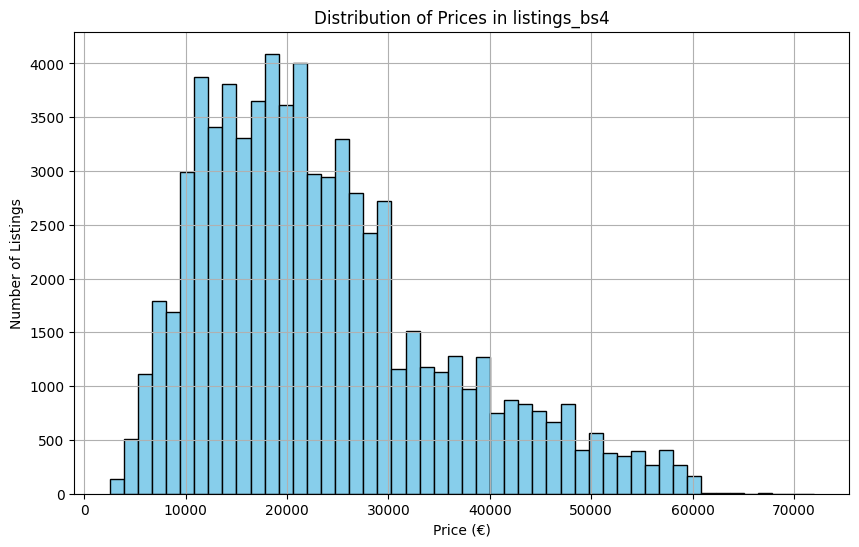

In [10]:
import matplotlib.pyplot as plt

# Extract numeric price values from combined_df['price']
price_series = final_df['price'].str.replace('€', '').str.replace(',', '').str.replace(' ', '').str.extract(r'(\d+)')[0].astype(float)

plt.figure(figsize=(10, 6))
plt.hist(price_series.dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Prices in listings_bs4')
plt.xlabel('Price (€)')
plt.ylabel('Number of Listings')
plt.grid(True)
plt.show()